In [ ]:
print("STEP 1 완료: corpus 생성")
print("STEP 1 완료: corpus 생성")

In [ ]:
from gensim.models import LdaMulticore

lda = LdaMulticore(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    passes=5,
    iterations=100,
    chunksize=2000,
    eval_every=None,
    workers=4,
    random_state=42
)


In [ ]:
import pandas as pd
import string
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TreebankWordTokenizer

from gensim import corpora, models
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [ ]:
df = pd.read_excel(
    "/Users/pinetree/tactile-design-LDA/20251230_scopus_733.xlsx"
)


In [ ]:
df["text"] = (
    df["Title"].fillna("") + " " +
    df["Author Keywords"].fillna("") + " " +
    df["Abstract"].fillna("")
)


In [ ]:
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
tokenizer = TreebankWordTokenizer()

custom_stop = {
    "study","paper","result","results","method","methods","analysis","approach",
    "conclusion","implication","implications","introduction","discussion",
    "based","using","use","used","new","one","two","three","within","across",
    "haptic","touch","tactile","design","process","explore","common","user",
    "work","practice","model","product","system","object","support","effect",
    "research","article","publisher","scopus","elsevier","make","tool","group","show","differ",
    "also","may","might","many","much","however","therefore","thus", "present","reflect","task","people","de",
    "et", "develop","present","provide","improve",'perform'
}

all_stop = stop_words | custom_stop
stemmed_stop = {stemmer.stem(w) for w in all_stop}

def preprocess_text(text):
    text = str(text).lower()
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    
    cleaned = []
    for t in tokens:
        if t in all_stop:
            continue
        t_stem = stemmer.stem(t)
        if t_stem in stemmed_stop:
            continue
        cleaned.append(t_stem)
    return cleaned


In [ ]:
df["tokens"] = df["text"].apply(preprocess_text)

print("문서 수:", len(df))
print("평균 토큰 수:", df["tokens"].apply(len).mean())


문서 수: 733
평균 토큰 수: 114.0


In [ ]:
dictionary = corpora.Dictionary(df["tokens"])
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in df["tokens"]]

print(f"Dictionary size: {len(dictionary)}")


Dictionary size: 1950


In [ ]:
# 사전에 어떤 단어가 남았는지 확인 (빈도수 상위 50개)
token_counts = {}
for doc in corpus:
    for word_id, count in doc:
        token_counts[word_id] = token_counts.get(word_id, 0) + count

# 단어와 빈도수 매칭해서 보기
sorted_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
for word_id, count in sorted_tokens[:30]:
    print(f"{dictionary[word_id]}: {count}")

interact: 699
experi: 604
visual: 480
perform: 390
music: 360
digit: 349
materi: 342
social: 334
particip: 319
learn: 315
technolog: 287
interfac: 278
inform: 268
commun: 262
provid: 253
control: 238
sound: 232
sensori: 230
student: 224
art: 222
cultur: 220
percept: 220
children: 215
data: 212
includ: 208
educ: 208
test: 202
access: 200
limit: 199
gener: 195


In [ ]:
num_topics = 4 # ← coherence 결과로 결정

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


Topic 1: 0.024*"music" + 0.017*"interact" + 0.017*"perform" + 0.014*"sound" + 0.014*"interfac" + 0.011*"instrument" + 0.010*"visual" + 0.009*"control" + 0.008*"devic" + 0.008*"comput"
Topic 2: 0.012*"materi" + 0.012*"experi" + 0.008*"social" + 0.008*"art" + 0.008*"digit" + 0.007*"architectur" + 0.007*"interact" + 0.007*"cultur" + 0.007*"commun" + 0.006*"technolog"
Topic 3: 0.010*"access" + 0.009*"experi" + 0.008*"particip" + 0.008*"stimul" + 0.007*"stimuli" + 0.007*"interact" + 0.007*"subject" + 0.007*"evalu" + 0.007*"museum" + 0.006*"provid"
Topic 4: 0.015*"learn" + 0.013*"children" + 0.010*"interact" + 0.010*"particip" + 0.008*"test" + 0.007*"visual" + 0.007*"student" + 0.007*"improv" + 0.007*"train" + 0.006*"experi"


In [ ]:
for i, topic in lda_model.print_topics(num_words=10):
    print(f"Topic {i+1}: {topic}")


중복포함단어수

In [ ]:
all_tokens = [token for doc in df["tokens"] for token in doc]
total_token_count = len(all_tokens)

print(f"중복 포함 단어 수 (Total tokens): {total_token_count}")


중복 포함 단어 수 (Total tokens): 83562


고유단어수

In [336]:
unique_token_count = len(set(all_tokens))

print(f"고유 단어 수 (Unique tokens): {unique_token_count}")


고유 단어 수 (Unique tokens): 9687


문서 평균 단어 수 (논문에 자주 쓰임)

In [337]:
avg_tokens_per_doc = df["tokens"].apply(len).mean()

print(f"문서당 평균 단어 수: {avg_tokens_per_doc:.2f}")


문서당 평균 단어 수: 114.00


(선택) Dictionary 기준 어휘 크기

In [338]:
print(f"LDA Dictionary 단어 수: {len(dictionary)}")


LDA Dictionary 단어 수: 1950


토픽 수 결정

In [339]:

def compute_coherence_only(dictionary, corpus, texts, start=2, limit=15, step=1):
    topic_nums = []
    coherence_scores = []

    for k in range(start, limit + 1, step):
        lda = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=20,
            alpha="auto"
        )

        coherence_model = CoherenceModel(
            model=lda,
            texts=texts,
            dictionary=dictionary,
            coherence="c_v"
        )
        coherence = coherence_model.get_coherence()

        topic_nums.append(k)
        coherence_scores.append(coherence)

        print(f"k={k:2d} | Coherence={coherence:.4f}")

    return topic_nums, coherence_scores


In [340]:
topic_nums, coherence_scores = compute_coherence_only(
    dictionary=dictionary,
    corpus=corpus,
    texts=df["tokens"],
    start=2,
    limit=15,
    step=1
)


k= 2 | Coherence=0.4118
k= 3 | Coherence=0.4492
k= 4 | Coherence=0.4215
k= 5 | Coherence=0.4455
k= 6 | Coherence=0.4150
k= 7 | Coherence=0.3993
k= 8 | Coherence=0.4012
k= 9 | Coherence=0.3661
k=10 | Coherence=0.3618
k=11 | Coherence=0.3389
k=12 | Coherence=0.3489
k=13 | Coherence=0.3684
k=14 | Coherence=0.3589
k=15 | Coherence=0.3577


In [341]:

optimal_k = topic_nums[np.argmax(coherence_scores)]
max_coherence = max(coherence_scores)

print(f"최대 Coherence: {max_coherence:.4f} (토픽 수 = {optimal_k})")


최대 Coherence: 0.4492 (토픽 수 = 3)


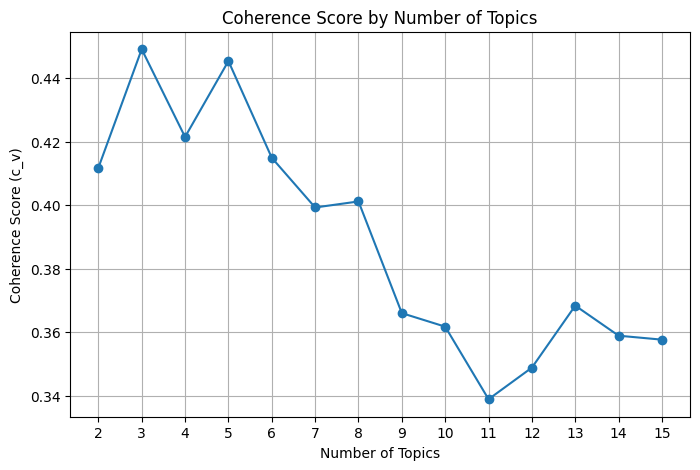

In [342]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(topic_nums, coherence_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score (c_v)")
plt.title("Coherence Score by Number of Topics")
plt.xticks(topic_nums)
plt.grid(True)
plt.show()


In [343]:
coherence_df = pd.DataFrame({
    "num_topics": topic_nums,
    "coherence": coherence_scores
})

coherence_df.to_csv(
    "데이터/lda_coherence.csv",
    index=False,
    encoding="utf-8-sig"
)

perplexity 최적값

In [344]:


def compute_perplexity_only(dictionary, corpus, start=2, limit=15, step=1):
    topic_nums = []
    perplexity_scores = []

    for k in range(start, limit + 1, step):
        lda = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=42,
            passes=20,
            alpha="auto"
        )

        # gensim은 log perplexity 반환
        log_perplexity = lda.log_perplexity(corpus)
        perplexity = np.exp(-log_perplexity)

        topic_nums.append(k)
        perplexity_scores.append(perplexity)

        print(f"k={k:2d} | Perplexity={perplexity:.2f}")

    return topic_nums, perplexity_scores


In [345]:
topic_nums, perplexity_scores = compute_perplexity_only(
    dictionary=dictionary,
    corpus=corpus,
    start=2,
    limit=15,
    step=1
)


k= 2 | Perplexity=1089.64
k= 3 | Perplexity=1075.94
k= 4 | Perplexity=1078.34
k= 5 | Perplexity=1085.32
k= 6 | Perplexity=1088.21
k= 7 | Perplexity=1112.44
k= 8 | Perplexity=1125.24
k= 9 | Perplexity=1136.18
k=10 | Perplexity=1145.57
k=11 | Perplexity=1166.02
k=12 | Perplexity=1184.47
k=13 | Perplexity=1172.54
k=14 | Perplexity=1172.61
k=15 | Perplexity=1177.40


In [346]:
optimal_k = topic_nums[np.argmin(perplexity_scores)]
min_perplexity = min(perplexity_scores)

print(f"최소 Perplexity: {min_perplexity:.2f} (토픽 수 = {optimal_k})")


최소 Perplexity: 1075.94 (토픽 수 = 3)


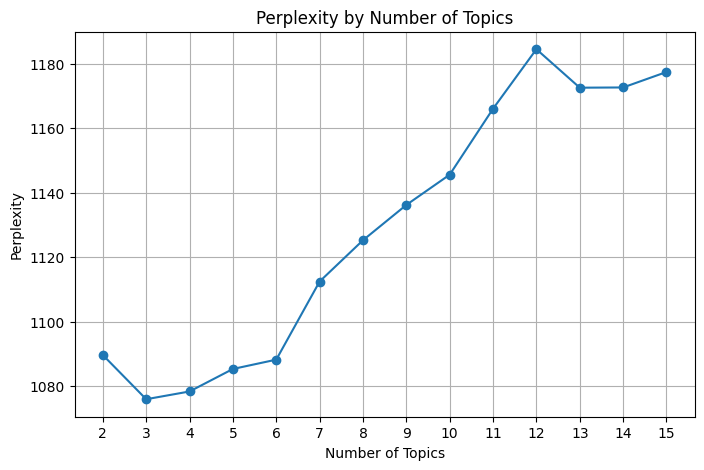

In [347]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexity_scores, marker="o")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity")
plt.title("Perplexity by Number of Topics")
plt.xticks(topic_nums)
plt.grid(True)
plt.show()


In [348]:

perplexity_df = pd.DataFrame({
    "num_topics": topic_nums,
    "perplexity": perplexity_scores
})

perplexity_df.to_csv(
    "데이터/lda_perplexity.csv",
    index=False,
    encoding="utf-8-sig"
)


토픽 내 단어 수 결정

In [349]:


topn = 15

rows = []
for topic_id in range(lda_model.num_topics):
    topic_terms = lda_model.show_topic(topic_id, topn=topn)
    for rank, (word, prob) in enumerate(topic_terms, start=1):
        rows.append({
            "topic": f"Topic {topic_id+1}",
            "rank": rank,
            "term": word,
            "probability": prob
        })

topic_terms_df_round = pd.DataFrame(rows).sort_values(["topic","rank"]).reset_index(drop=True)
topic_terms_df_round["cum_prob"] = topic_terms_df_round.groupby("topic")["probability"].cumsum()



In [350]:
topic_terms_df_round.groupby("topic")["cum_prob"].max().sort_values()


topic
Topic 3    0.100873
Topic 2    0.107748
Topic 4    0.115662
Topic 1    0.164402
Name: cum_prob, dtype: float32

In [351]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
    .groupby("topic")["probability"]
    .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,music,0.024086,0.024086
1,Topic 1,2,interact,0.017398,0.041484
2,Topic 1,3,perform,0.016967,0.058451
3,Topic 1,4,sound,0.013747,0.072198
4,Topic 1,5,interfac,0.013526,0.085724
5,Topic 1,6,instrument,0.010547,0.096271
6,Topic 1,7,visual,0.009599,0.105870
7,Topic 1,8,control,0.009152,0.115022
8,Topic 1,9,devic,0.008002,0.123023
9,Topic 1,10,comput,0.007729,0.130752


In [352]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
        .groupby("topic")["probability"]
        .cumsum()
)

topic_terms_df_round


,topic,rank,term,probability,cum_prob
0,Topic 1,1,music,0.024086,0.024086
1,Topic 1,2,interact,0.017398,0.041484
2,Topic 1,3,perform,0.016967,0.058451
3,Topic 1,4,sound,0.013747,0.072198
4,Topic 1,5,interfac,0.013526,0.085724
5,Topic 1,6,instrument,0.010547,0.096271
6,Topic 1,7,visual,0.009599,0.105870
7,Topic 1,8,control,0.009152,0.115022
8,Topic 1,9,devic,0.008002,0.123023
9,Topic 1,10,comput,0.007729,0.130752


시각화

In [353]:

num_topics = 4   # coherence로 결정한 값

lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=20,
    alpha="auto"
)


In [354]:

print(lda_model)


LdaModel<num_terms=1950, num_topics=4, decay=0.5, chunksize=2000>


In [355]:
pip install "pandas==1.5.3"


85686.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


In [356]:
import pandas as pd, pyLDAvis
print("pandas:", pd.__version__)
print("pyLDAvis:", pyLDAvis.__version__)


pandas: 1.5.3
pyLDAvis: 3.4.0


In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from IPython.display import display

vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False)

pyLDAvis.enable_notebook()
display(vis_data)



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


ERROR:tornado.general:SEND Error: Host unreachable


🔹 (A) 토픽별 상위 단어 Bar Chart

“각 토픽을 구성하는 핵심 단어는 무엇인가”

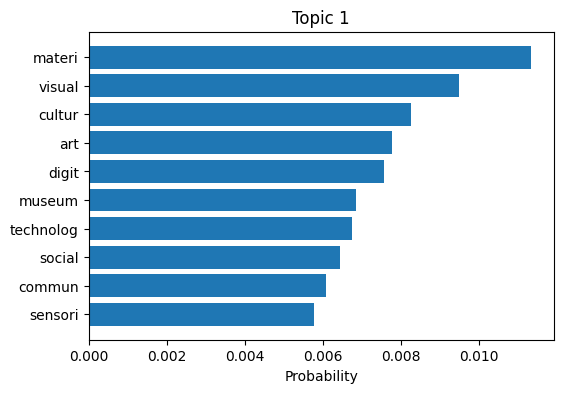

In [ ]:
import matplotlib.pyplot as plt

def plot_top_words(lda_model, dictionary, topic_id, topn=10):
    words_probs = lda_model.show_topic(topic_id, topn=topn)
    words, probs = zip(*words_probs)

    plt.figure(figsize=(6,4))
    plt.barh(words, probs)
    plt.gca().invert_yaxis()
    plt.title(f"Topic {topic_id+1}")
    plt.xlabel("Probability")
    plt.show()

# 예시
plot_top_words(lda_model, dictionary, topic_id=0)


🔹 (B) 모든 토픽 한 번에 (Subplot)

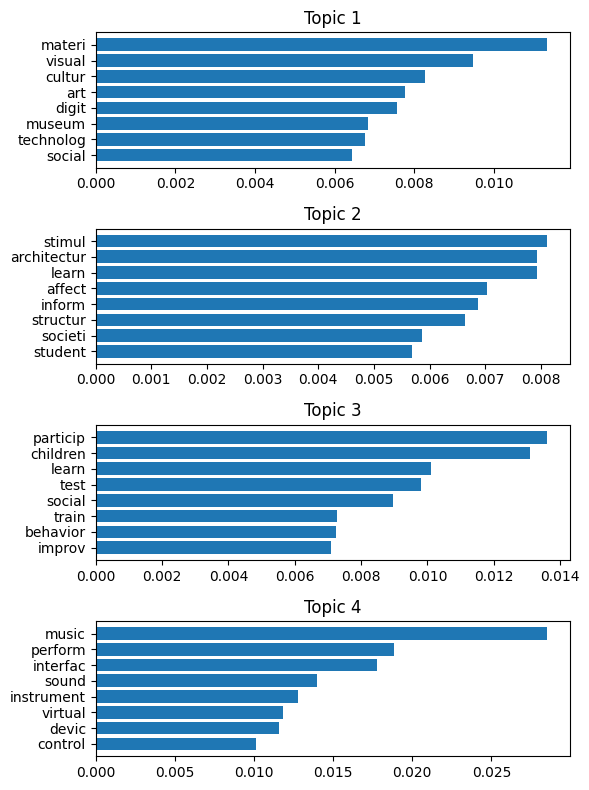

In [ ]:
fig, axes = plt.subplots(lda_model.num_topics, 1, figsize=(6, 2*lda_model.num_topics))

for i, ax in enumerate(axes):
    words_probs = lda_model.show_topic(i, topn=8)
    words, probs = zip(*words_probs)
    ax.barh(words, probs)
    ax.set_title(f"Topic {i+1}")
    ax.invert_yaxis()

plt.tight_layout()
plt.show()


In [ ]:
topic_terms_df_round["cum_prob"] = (
    topic_terms_df_round
        .groupby("topic")["probability"]
        .cumsum()
)

topic_terms_df_round

,topic,rank,term,probability,cum_prob
0,Topic 1,1,materi,0.013444,0.013444
1,Topic 1,2,visual,0.010640,0.024083
2,Topic 1,3,cultur,0.008515,0.032599
3,Topic 1,4,art,0.008293,0.040892
4,Topic 1,5,digit,0.008232,0.049124
...,...,...,...,...,...
70,Topic 5,11,memori,0.005058,0.082777
71,Topic 5,12,robot,0.004961,0.087738
72,Topic 5,13,care,0.004817,0.092554
73,Topic 5,14,relat,0.004721,0.097275


In [ ]:
doc_topics = [
    [prob for _, prob in lda_model.get_document_topics(bow, minimum_probability=0)]
    for bow in corpus
]

doc_topic_df = pd.DataFrame(doc_topics)

doc_topic_df.head()


,0,1,2,3
0,0.628965,0.001304,0.315230,0.054501
1,0.729218,0.000605,0.000642,0.269535
2,0.488504,0.510108,0.000718,0.000669
3,0.001506,0.846556,0.000920,0.151018
4,0.447488,0.000983,0.415411,0.136118


2️⃣ 문서–토픽 관계 시각화 (해석용으로 매우 중요)
🔹 (C) 문서별 주요 토픽 분포 (Stacked Bar)

“문서들은 어떤 토픽 조합으로 구성되는가”

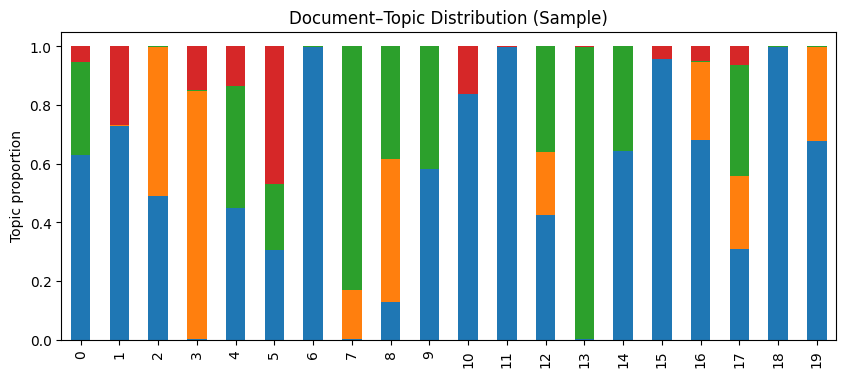

In [ ]:
doc_topic_df.iloc[:20].plot(
    kind="bar",
    stacked=True,
    figsize=(10,4),
    legend=False
)
plt.ylabel("Topic proportion")
plt.title("Document–Topic Distribution (Sample)")
plt.show()


🔹 (D) 각 토픽이 차지하는 평균 비중

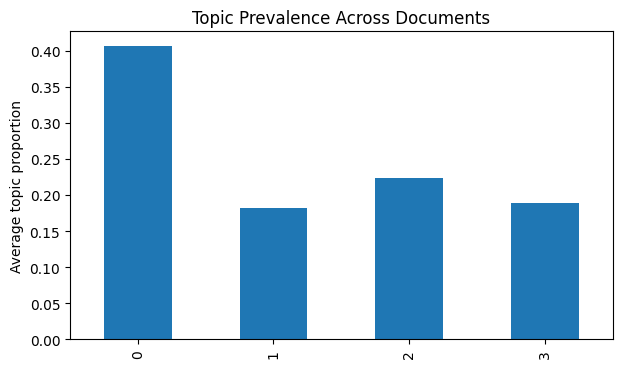

In [ ]:
topic_prevalence = doc_topic_df.mean()

topic_prevalence.plot(
    kind="bar",
    figsize=(7,4)
)
plt.ylabel("Average topic proportion")
plt.title("Topic Prevalence Across Documents")
plt.show()


3️⃣ 토픽 간 유사도 / 구조 시각화 (고급)
🔹 (E) 토픽 간 코사인 유사도 Heatmap

“토픽들이 서로 얼마나 겹치는가”

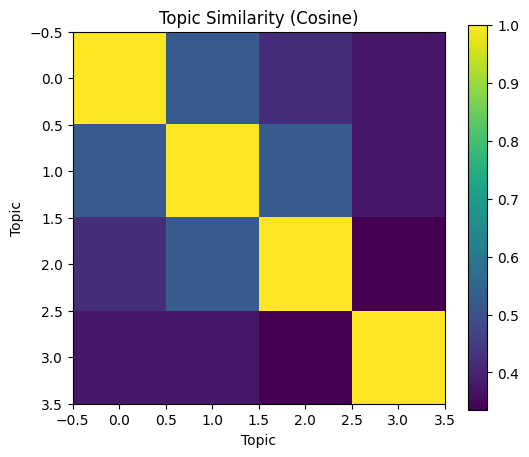

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

topic_word_matrix = lda_model.get_topics()
similarity = cosine_similarity(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.imshow(similarity, cmap="viridis")
plt.colorbar()
plt.title("Topic Similarity (Cosine)")
plt.xlabel("Topic")
plt.ylabel("Topic")
plt.show()


🔹 (F) PCA / t-SNE로 토픽 위치 시각화

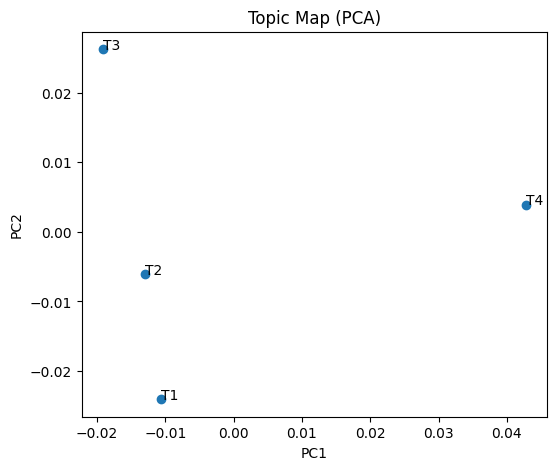

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
coords = pca.fit_transform(topic_word_matrix)

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1])

for i in range(len(coords)):
    plt.text(coords[i,0], coords[i,1], f"T{i+1}")

plt.title("Topic Map (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


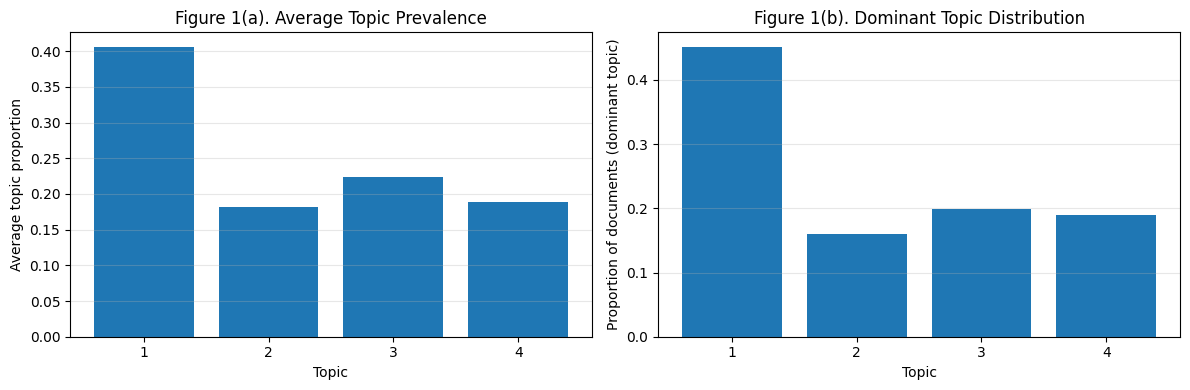

,topic,avg_prevalence,dominant_doc_count,dominant_doc_ratio
0,Topic 1,0.406234,331,0.451569
1,Topic 2,0.181408,117,0.159618
2,Topic 3,0.223998,146,0.199181
3,Topic 4,0.188361,139,0.189632


In [ ]:

import matplotlib.pyplot as plt

# =========================================================
# Figure 1(a) Average Topic Prevalence
#  + Figure 1(b) Dominant Topic Distribution
# =========================================================

K = lda_model.num_topics

# 1) 문서-토픽 분포 행렬 만들기 (N_docs x K)
doc_topic = np.zeros((len(corpus), K), dtype=float)
for i, bow in enumerate(corpus):
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        doc_topic[i, tid] = prob

doc_topic_df = pd.DataFrame(
    doc_topic,
    columns=[f"Topic {i+1}" for i in range(K)]
)

# 2) (a) 평균 토픽 비중
avg_prevalence = doc_topic_df.mean(axis=0).values  # 길이 K

# 3) (b) 지배적 토픽(각 문서에서 가장 큰 토픽) 빈도/비율
dominant_topic_idx = doc_topic_df.values.argmax(axis=1)  # 0..K-1
dominant_counts = pd.Series(dominant_topic_idx).value_counts().sort_index()
dominant_counts = dominant_counts.reindex(range(K), fill_value=0)

dominant_ratio = dominant_counts / len(corpus)

# 4) Figure 1(a)+(b) 그리기
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---- (a) Average Topic Prevalence ----
axes[0].bar(range(1, K+1), avg_prevalence)
axes[0].set_title("Figure 1(a). Average Topic Prevalence")
axes[0].set_xlabel("Topic")
axes[0].set_ylabel("Average topic proportion")
axes[0].set_xticks(range(1, K+1))
axes[0].grid(True, axis="y", alpha=0.3)

# ---- (b) Dominant Topic Distribution ----
axes[1].bar(range(1, K+1), dominant_ratio.values)
axes[1].set_title("Figure 1(b). Dominant Topic Distribution")
axes[1].set_xlabel("Topic")
axes[1].set_ylabel("Proportion of documents (dominant topic)")
axes[1].set_xticks(range(1, K+1))
axes[1].grid(True, axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# 5) (선택) 표로 저장 (논문 표/부록/검증용)
out_df = pd.DataFrame({
    "topic": [f"Topic {i+1}" for i in range(K)],
    "avg_prevalence": avg_prevalence,
    "dominant_doc_count": dominant_counts.values,
    "dominant_doc_ratio": dominant_ratio.values
})

out_df


A) 토픽별 비중 변화: 연도별 Topic Prevalence Over Time
1) 연도 컬럼 자동 탐색 + 정리

Scopus 엑셀은 보통 Year, Publication Year, Year Published 같은 이름이 많아서 자동으로 찾아 씁니다.

In [ ]:

# 1) 연도 컬럼 찾기 (가능한 후보들)
year_candidates = [
    "Year", "Publication Year", "Year Published", "PubYear", "PY", "출판연도", "연도"
]

year_col = None
for c in year_candidates:
    if c in df.columns:
        year_col = c
        break

if year_col is None:
    raise ValueError(f"연도 컬럼을 못 찾았어요. df.columns에서 연도 컬럼명을 확인해 주세요.\n{list(df.columns)}")

print("연도 컬럼:", year_col)

# 2) 연도 정수화
years = pd.to_numeric(df[year_col], errors="coerce").astype("Int64")


연도 컬럼: Year


In [ ]:
[c for c in df.columns if "year" in c.lower() or "date" in c.lower()]


['Year']

In [ ]:

# ✅ 문서(행) 수와 동일한 길이로 years 생성
years = pd.to_numeric(df[year_col], errors="coerce")

print("문서 수:", len(df), " / years 길이:", len(years))
years.head()


문서 수: 733  / years 길이: 733


0    2026
1    2025
2    2025
3    2025
4    2025
Name: Year, dtype: int64

In [ ]:
years.value_counts().sort_index()


1974     2
1976     2
1980     2
1981     2
1982     2
1983     1
1984     4
1985     2
1986     3
1987     2
1989     4
1990     5
1991     3
1992     2
1993     1
1994     2
1995     2
1996     2
1997    11
1998     4
1999     2
2000     3
2001     5
2002     3
2003     4
2004     3
2005    14
2006    10
2007    11
2008    12
2009    17
2010    19
2011    19
2012    21
2013    24
2014    31
2015    33
2016    20
2017    49
2018    33
2019    33
2020    41
2021    53
2022    40
2023    49
2024    56
2025    69
2026     1
Name: Year, dtype: int64

2) 연도별 평균 토픽 비중 계산 + 라인 플롯

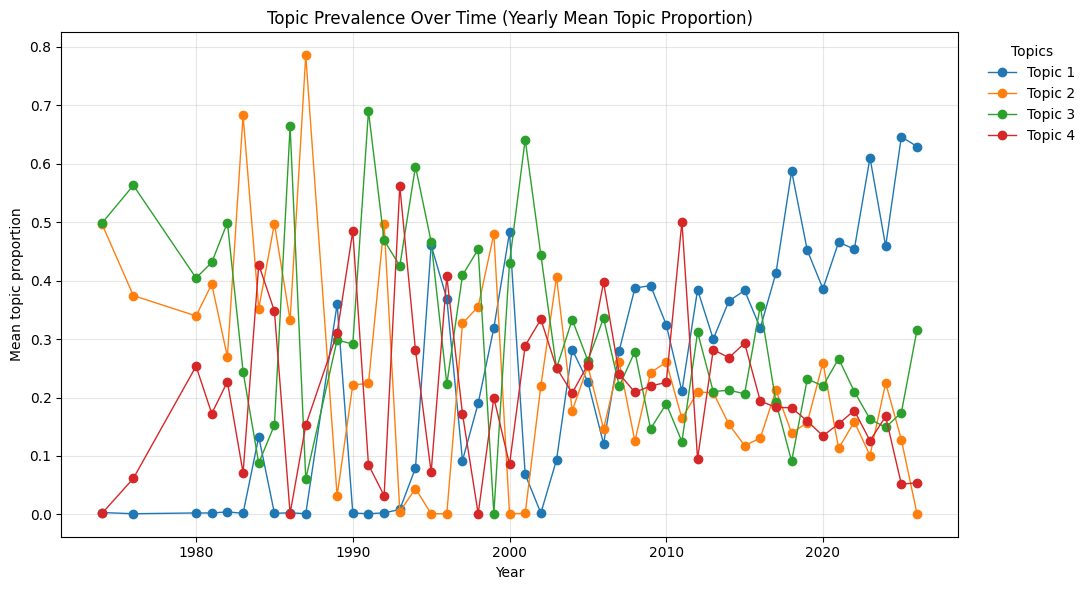

,Topic 1,Topic 2,Topic 3,Topic 4
year,,,,
1974,0.003296,0.496474,0.498354,0.001876
1976,0.001264,0.374281,0.562749,0.061707
1980,0.002574,0.339501,0.404422,0.253503
1981,0.002553,0.393930,0.430984,0.172534
1982,0.004444,0.269568,0.499052,0.226936


In [ ]:
# =========================================================
# 연도별 토픽 비중 (Topic Prevalence Over Time)
# - 컬러–토픽 대응 명확
# - 정확한 수치(yearly) 확인 가능
# =========================================================

# 1) doc_topic_df와 연도 결합
dt = doc_topic_df.copy()
dt["year"] = years

# 2) 결측 연도 제거 + 정수형 변환
dt = dt.dropna(subset=["year"])
dt["year"] = dt["year"].astype(int)

# 3) 연도별 평균 토픽 비중 계산
yearly = (
    dt.groupby("year")[doc_topic_df.columns]
    .mean()
    .sort_index()
)

# 4) 시각화
plt.figure(figsize=(11, 6))

for col in yearly.columns:
    plt.plot(
        yearly.index,
        yearly[col],
        marker="o",
        linewidth=1,
        label=col     # ✅ 컬러–토픽 대응 핵심
    )

plt.title("Topic Prevalence Over Time (Yearly Mean Topic Proportion)")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)

# ✅ 범례 추가 (논문용 정석 위치)
plt.legend(
    title="Topics",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.show()

# 5) 정확한 데이터값 확인
yearly.head()

In [ ]:
# 5) 정확한 데이터값 확인
yearly.head()

yearly.to_excel(
    "yearly_topic_prevalence.xlsx",
    sheet_name="yearly_topic_prevalence"
)


📌 논문에선 보통 상위 N개 토픽만 보여주는 게 더 깔끔합니다. (예: 평균 비중 상위 4개)

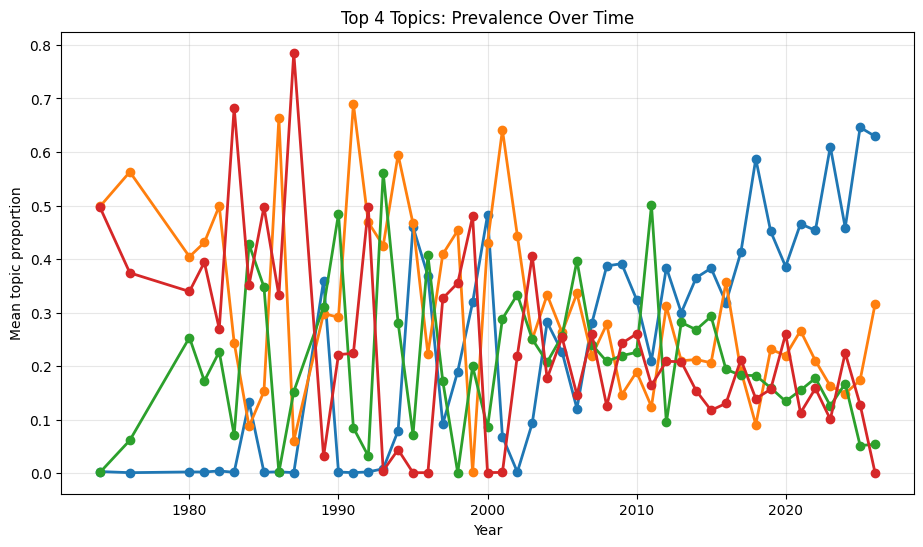

['Topic 1', 'Topic 3', 'Topic 4', 'Topic 2']

In [ ]:

topN = 4
top_topics = doc_topic_df.mean().sort_values(ascending=False).head(topN).index

plt.figure(figsize=(11, 6))
for col in top_topics:
    plt.plot(yearly.index, yearly[col], marker="o", linewidth=2)

plt.title(f"Top {topN} Topics: Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.show()

top_topics.tolist()


B) “주기적 상승/하락 패턴” 정량화

연도 데이터는 보통 계절성(12개월)은 없지만, “주기성(몇 년 단위 등)” 주장은 가능해요. 논문/리뷰 대응에 가장 무난한 조합은:

이동평균(스무딩)으로 추세 vs 변동 분리

ACF(자기상관)으로 주기 후보(몇 년 단위) 제시

1) 이동평균(rolling mean)

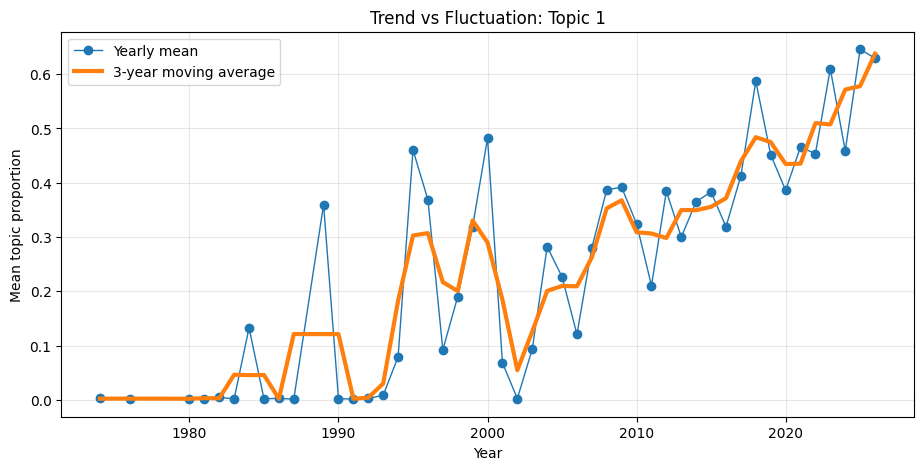

In [ ]:

topic_to_check = top_topics[0]  # 가장 큰 토픽 하나부터 체크 (원하면 바꿔도 됨)

series = yearly[topic_to_check].copy()
roll = series.rolling(window=3, center=True, min_periods=1).mean()  # 3년 이동평균

plt.figure(figsize=(11, 5))
plt.plot(series.index, series.values, marker="o", linewidth=1, label="Yearly mean")
plt.plot(roll.index, roll.values, linewidth=3, label="3-year moving average")
plt.title(f"Trend vs Fluctuation: {topic_to_check}")
plt.xlabel("Year")
plt.ylabel("Mean topic proportion")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


2) ACF(자기상관) — “몇 년 주기” 힌트
📌 해석 포인트(논문용):

Lag 2~5에서 양의 상관이 반복되면 “몇 년 단위의 반복적 변동 가능성”을 탐색적으로 제시할 수 있어요.

단, 표본연도 수가 적으면(예: 10년 이하) 강한 주장 금지하고 “exploratory”로 쓰는 게 안전합니다.

/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_74898/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
/var/folders/dw/s7gyvbt14193__4lgngl_yr80000gn/T/ipykernel_74898/3901874424.py:17: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)


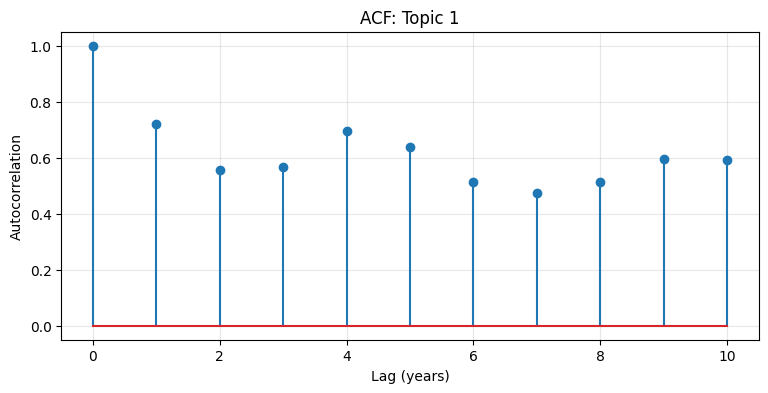

In [ ]:

def plot_acf_manual(x, max_lag=10, title="ACF"):
    x = np.asarray(x, dtype=float)
    x = x - np.nanmean(x)
    x = x[~np.isnan(x)]
    n = len(x)
    if n < 3:
        raise ValueError("ACF를 계산하기엔 연도 데이터 포인트가 너무 적어요.")

    acf_vals = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_vals.append(1.0)
        else:
            acf_vals.append(np.corrcoef(x[:-lag], x[lag:])[0, 1])

    plt.figure(figsize=(9, 4))
    plt.stem(range(max_lag + 1), acf_vals, use_line_collection=True)
    plt.title(title)
    plt.xlabel("Lag (years)")
    plt.ylabel("Autocorrelation")
    plt.grid(True, alpha=0.3)
    plt.show()

plot_acf_manual(series.values, max_lag=10, title=f"ACF: {topic_to_check}")


C) 토픽 간 유사도 매트릭스 (Topic Similarity Matrix)

가장 보편적이고 리뷰어 설득에 바로 먹힙니다.

1) 토픽-단어 분포 행렬 기반 코사인 유사도

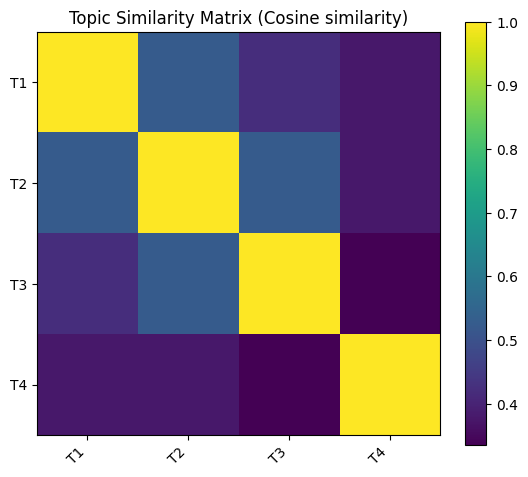

,T1,T2,T3,T4
T1,1.000,0.525,0.421,0.378
T2,0.525,1.000,0.526,0.379
T3,0.421,0.526,1.000,0.335
T4,0.378,0.379,0.335,1.000


In [ ]:


topic_word = lda_model.get_topics()   # (K x V) 토픽-단어 확률행렬
sim = cosine_similarity(topic_word)  # (K x K)

plt.figure(figsize=(6.5, 5.5))
plt.imshow(sim)
plt.colorbar()
plt.title("Topic Similarity Matrix (Cosine similarity)")
plt.xticks(range(K), [f"T{i+1}" for i in range(K)], rotation=45, ha="right")
plt.yticks(range(K), [f"T{i+1}" for i in range(K)])
plt.grid(False)
plt.show()

sim_df = pd.DataFrame(sim, index=[f"T{i+1}" for i in range(K)], columns=[f"T{i+1}" for i in range(K)])
sim_df.round(3).head()


1️⃣ 토픽별 연도 변화 기울기(slope) 계산

단순선형회귀: topic_prevalence=β0​+β1​⋅year

In [ ]:

years = yearly.index.values.astype(float)

slope_rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        slope = np.nan
        r2 = np.nan
    else:
        # 1차 회귀
        coef = np.polyfit(x, y, 1)
        slope = coef[0]

        # R^2 계산 (설명력 보조 지표)
        y_hat = np.polyval(coef, x)
        ss_res = np.sum((y - y_hat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    slope_rows.append({
        "topic": topic,
        "slope": slope,
        "r2": r2
    })

slope_df = pd.DataFrame(slope_rows)
slope_df


,topic,slope,r2
0,Topic 1,0.011655,0.678272
1,Topic 2,-0.005980,0.248371
2,Topic 3,-0.005256,0.217178
3,Topic 4,-0.000418,0.002107


In [ ]:

slope_df_sorted = slope_df.sort_values("slope", ascending=False)
slope_df_sorted


,topic,slope,r2
0,Topic 1,0.011655,0.678272
3,Topic 4,-0.000418,0.002107
2,Topic 3,-0.005256,0.217178
1,Topic 2,-0.005980,0.248371


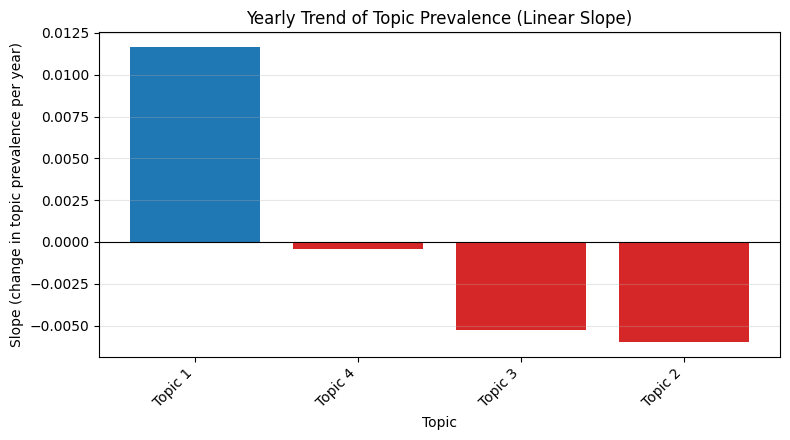

In [ ]:

plt.figure(figsize=(8, 4.5))

colors = ["#1f77b4" if s > 0 else "#d62728" for s in slope_df_sorted["slope"]]

plt.bar(
    slope_df_sorted["topic"],
    slope_df_sorted["slope"],
    color=colors
)

plt.axhline(0, color="black", linewidth=0.8)
plt.ylabel("Slope (change in topic prevalence per year)")
plt.xlabel("Topic")
plt.title("Yearly Trend of Topic Prevalence (Linear Slope)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

slope_df_sorted["slope_z"] = (
    (slope_df_sorted["slope"] - slope_df_sorted["slope"].mean())
    / slope_df_sorted["slope"].std()
)

slope_df_sorted


,topic,slope,r2,slope_z
0,Topic 1,0.011655,0.678272,1.429562
3,Topic 4,-0.000418,0.002107,-0.051321
2,Topic 3,-0.005256,0.217178,-0.644718
1,Topic 2,-0.005980,0.248371,-0.733524


In [ ]:
!pip install statsmodels

In [ ]:

import statsmodels.api as sm

years = yearly.index.values.astype(float)

rows = []

for topic in yearly.columns:
    y = yearly[topic].values.astype(float)

    # 결측 제거
    mask = ~np.isnan(y)
    x = years[mask]
    y = y[mask]

    if len(x) < 3:
        rows.append({
            "topic": topic,
            "slope": np.nan,
            "p_value": np.nan,
            "r2": np.nan,
            "n_years": len(x)
        })
        continue

    X = sm.add_constant(x)  # [1, year]
    model = sm.OLS(y, X).fit()

    rows.append({
        "topic": topic,
        "slope": model.params[1],          # β1
        "p_value": model.pvalues[1],       # p-value for slope
        "r2": model.rsquared,              # R²
        "n_years": int(model.nobs)
    })

reg_df = pd.DataFrame(rows)
reg_df


,topic,slope,p_value,r2,n_years
0,Topic 1,0.011655,6.615182e-13,0.678272,48
1,Topic 2,-0.005980,3.123219e-04,0.248371,48
2,Topic 3,-0.005256,8.431110e-04,0.217178,48
3,Topic 4,-0.000418,7.567283e-01,0.002107,48


In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

# 1) 토픽-단어 분포
topic_word = lda_model.get_topics()   # (K x V)

# 2) 코사인 유사도 → 거리
sim = cosine_similarity(topic_word)
dist = 1 - sim

# 3) MDS로 2차원 배치
mds = MDS(
    n_components=2,
    dissimilarity="precomputed",
    random_state=42
)
coords = mds.fit_transform(dist)

coords_df = pd.DataFrame(
    coords,
    columns=["x_struct", "y_struct"]
)
coords_df["topic"] = [f"Topic {i+1}" for i in range(K)]

coords_df


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


,x_struct,y_struct,topic
0,-0.031336,0.330787,Topic 1
1,-0.288956,0.022067,Topic 2
2,-0.097330,-0.337352,Topic 3
3,0.417623,-0.015502,Topic 4


In [ ]:

plot_df = coords_df.merge(reg_df, on="topic", how="left")
plot_df


,x_struct,y_struct,topic,slope,p_value,r2,n_years
0,-0.031336,0.330787,Topic 1,0.011655,6.615182e-13,0.678272,48
1,-0.288956,0.022067,Topic 2,-0.005980,3.123219e-04,0.248371,48
2,-0.097330,-0.337352,Topic 3,-0.005256,8.431110e-04,0.217178,48
3,0.417623,-0.015502,Topic 4,-0.000418,7.567283e-01,0.002107,48


Slope vs Similarity 2D 맵 그리기 (논문용 Figure)

① 증가/감소의 방향성

X축 기준으로 토픽이 증가군 / 감소군으로 명확히 분리됨

② 구조적 군집

Y축에서 가까운 토픽들은 유사한 단어 분포

“증가하는 토픽이 특정 구조 영역에 집중되는지” 논의 가능

③ 의미 있는 변화만 강조

p < .05 토픽 → 진하게 표시

비유의 토픽 → 반투명 처리

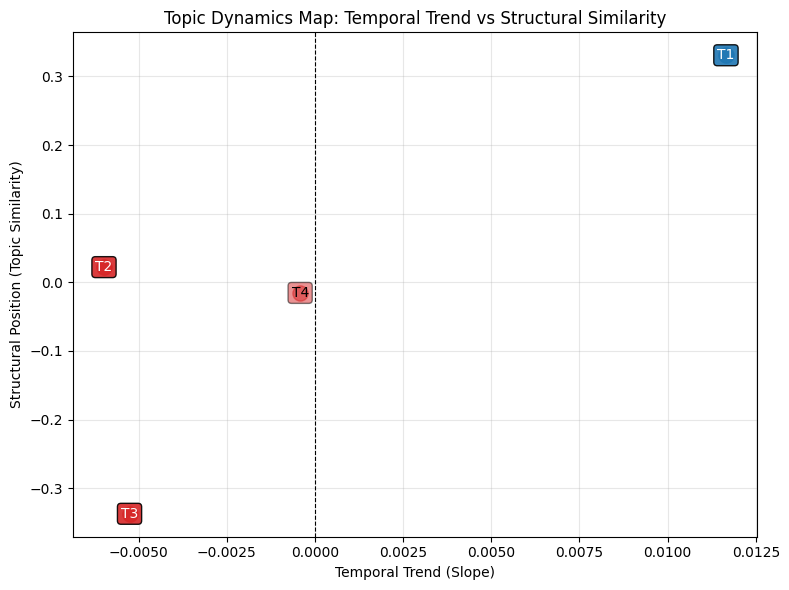

In [ ]:

plt.figure(figsize=(8, 6))

for _, row in plot_df.iterrows():
    color = "#1f77b4" if row["slope"] > 0 else "#d62728"
    alpha = 0.9 if row["p_value"] < 0.05 else 0.5  # 유의한 토픽 강조

    plt.scatter(
        row["slope"],
        row["y_struct"],
        color=color,
        s=120,
        alpha=alpha
    )

    plt.text(
        row["slope"],
        row["y_struct"],
        row["topic"].replace("Topic ", "T"),
        fontsize=10,
        ha="center",
        va="center",
        color="white" if alpha > 0.7 else "black",
        bbox=dict(boxstyle="round,pad=0.25", fc=color, alpha=alpha)
    )

plt.axvline(0, color="black", linestyle="--", linewidth=0.8)

plt.xlabel("Temporal Trend (Slope)")
plt.ylabel("Structural Position (Topic Similarity)")
plt.title("Topic Dynamics Map: Temporal Trend vs Structural Similarity")

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:

import numpy as np

# =========================================================
# 1️⃣ 데이터 복사
# =========================================================
df_year = df.copy()

# =========================================================
# 2️⃣ 연도 컬럼 정리
# =========================================================
df_year["year"] = pd.to_numeric(df_year["Year"], errors="coerce")
df_year = df_year.dropna(subset=["year"])
df_year["year"] = df_year["year"].astype(int)

# =========================================================
# 3️⃣ 1974년 기준 5년 단위 구간 생성
# =========================================================
START_YEAR = 1971
BIN_SIZE = 5
END_YEAR = 2025

# ✅ 2025년까지만 필터링
df_year = df_year[df_year["year"] <= END_YEAR]

df_year["period_start"] = (
    START_YEAR + ((df_year["year"] - START_YEAR) // BIN_SIZE) * BIN_SIZE

)

df_year["period_label"] = (
    df_year["period_start"].astype(str)
    + "-"
    + (df_year["period_start"] + BIN_SIZE - 1).astype(str)
)

# =========================================================
# 4️⃣ 5년 단위 논문 수
# =========================================================
paper_counts_5y = (
    df_year
    .groupby("period_label")
    .size()
    .sort_index()
)

# =========================================================
# 5️⃣ 5년 단위 증감(Δ)
# =========================================================
paper_change_5y = paper_counts_5y.diff()

# =========================================================
# 6️⃣ 결과 출력
# =========================================================
paper_counts_5y, paper_change_5y


(period_label
 1971-1975      2
 1976-1980      4
 1981-1985     11
 1986-1990     14
 1991-1995     10
 1996-2000     22
 2001-2005     29
 2006-2010     69
 2011-2015    128
 2016-2020    176
 2021-2025    267
 dtype: int64,
 period_label
 1971-1975     NaN
 1976-1980     2.0
 1981-1985     7.0
 1986-1990     3.0
 1991-1995    -4.0
 1996-2000    12.0
 2001-2005     7.0
 2006-2010    40.0
 2011-2015    59.0
 2016-2020    48.0
 2021-2025    91.0
 dtype: float64)

In [ ]:
# =========================================================
# 1️⃣ 5년 단위 집계 테이블 생성
# =========================================================
table_5y = paper_counts_5y.reset_index()
table_5y.columns = ["Period", "Paper_Count"]

# =========================================================
# 2️⃣ 전년비(이전 구간 대비 증감률, %) 계산
# =========================================================
table_5y["YoY_%"] = table_5y["Paper_Count"].pct_change() * 100

# =========================================================
# 3️⃣ 보기 좋게 반올림
# =========================================================
table_5y["YoY_%"] = table_5y["YoY_%"].round(2)

table_5y


,Period,Paper_Count,YoY_%
0,1971-1975,2,NaN
1,1976-1980,4,100.00
2,1981-1985,11,175.00
3,1986-1990,14,27.27
4,1991-1995,10,-28.57
5,1996-2000,22,120.00
6,2001-2005,29,31.82
7,2006-2010,69,137.93
8,2011-2015,128,85.51
9,2016-2020,176,37.50


In [ ]:
table_5y.to_csv("paper_count_5year_yoy.csv", index=False, encoding="utf-8-sig")


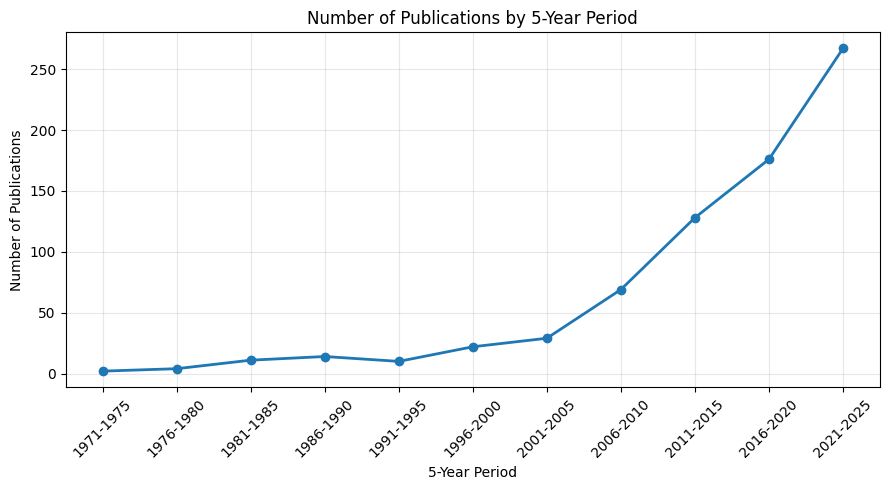

In [ ]:
plt.figure(figsize=(9, 5))
plt.plot(paper_counts_5y.index, paper_counts_5y.values, marker="o", linewidth=2)
plt.title("Number of Publications by 5-Year Period")
plt.xlabel("5-Year Period")
plt.ylabel("Number of Publications")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:


# 토픽별 평균 비중 계산
topic_share = doc_topic_dist.mean(axis=0)

# 데이터프레임으로 정리
df_topic_share = pd.DataFrame({
    "Topic": [f"Topic {i+1}" for i in range(len(topic_share))],
    "Proportion": topic_share
})

# 정렬 (선택)
df_topic_share = df_topic_share.sort_values("Proportion", ascending=False)

df_topic_share


,Topic,Proportion
0,Topic 1,0.406236
2,Topic 3,0.223997
3,Topic 4,0.188367
1,Topic 2,0.181401


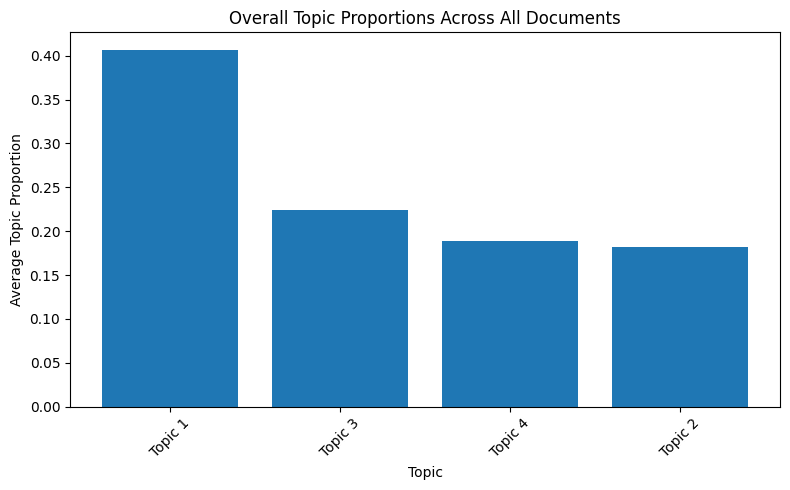

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(df_topic_share["Topic"], df_topic_share["Proportion"])
plt.ylabel("Average Topic Proportion")
plt.xlabel("Topic")
plt.title("Overall Topic Proportions Across All Documents")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


그림 X. 전체 문서에서 토픽별 평균 비중의 누적 분포
(각 문서의 토픽 확률을 평균하여 산출)

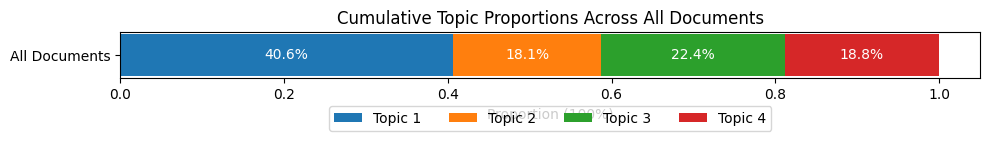

In [ ]:


# =========================================================
# 1️⃣ 토픽 비중 계산
# =========================================================
topic_share = doc_topic_dist.mean(axis=0)

df_topic_share = pd.DataFrame({
    "Topic": [f"Topic {i+1}" for i in range(len(topic_share))],
    "Proportion": topic_share
})

# =========================================================
# 2️⃣ 누적 막대 + 퍼센티지 표시
# =========================================================
plt.figure(figsize=(10, 2))

left = 0
colors = plt.cm.tab10.colors

for i, row in df_topic_share.iterrows():
    width = row["Proportion"]
    percent = width * 100

    plt.barh(
        ["All Documents"],
        width,
        left=left,
        color=colors[i % len(colors)],
        label=row["Topic"]
    )

    # 퍼센티지 텍스트 (가운데 배치)
    plt.text(
        left + width / 2,
        0,
        f"{percent:.1f}%",
        va="center",
        ha="center",
        fontsize=10,
        color="white" if percent > 7 else "black"
    )

    left += width

plt.xlabel("Proportion (100%)")
plt.title("Cumulative Topic Proportions Across All Documents")

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.45),
    ncol=len(df_topic_share)
)

plt.tight_layout()
plt.show()
